In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [1]:
class env():
    def __init__(self, alpha=0.1, gamma=1, num_states=5):
        self.ground_truth = np.append(np.arange(1+num_states)/(1+num_states), 0)
        self.value = np.concatenate([[0], np.ones(num_states)/2, [0]])
        self.num_states = num_states
        self.alpha = alpha
        self.gamma = gamma
        self.rms_hist = [self.RMS()]

    def learnMC(self):
        for i in range(100):
            state = 3
            visit = []
            while 1 <= state <= self.num_states:
                visit.append(state)
                state += (random.random() > 0.5)*2-1
            returnG = state // (self.num_states+1)
            for state in visit:
                self.value[state] += self.alpha*(returnG - self.value[state])
            self.rms_hist.append(self.RMS())
        return self.rms_hist
    
    def learnTD(self):
        for i in range(100):
            new = 3
            while 1 <= new <= self.num_states:
                state = new
                new = state + (random.random()>0.5)*2-1
                reward = new // (self.num_states+1)
                self.value[state] += self.alpha*(reward + self.gamma*self.value[new] - self.value[state])
            self.rms_hist.append(self.RMS())
        return self.rms_hist
    
    def learnTDN(self, n):
        for i in range(10):
            state = 3
            visit = []
            while 1 <= state <= self.num_states:
                visit.append(state)
                state += (random.random() > 0.5)*2-1
            reward = state // (self.num_states+1)
            for i in range(len(visit)):
                state = visit[i]
                if i+n >= len(visit):
                    future = reward
                else:
                    future = self.value[visit[i+n]]
                self.value[state] += self.alpha*(future - self.value[state])
        return self.RMS()

    def RMS(self):
        return np.sqrt(np.sum(np.square(self.value - self.ground_truth))/5)

    def plotRMS(self):
        plt.plot(self.rms_hist)
        plt.show()


class windyGrid():
    def __init__(self):
        self.H, self.W, self.C = 7, 10, 4
        self.Q = np.zeros([self.H, self.W, self.C])
        self.actions = [(1,0), (0,1), (-1,0), (0,-1)]
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.epsilon = 0.1
        self.initial_state = (3, 0)
        self.terminal_state = (3, 7)
        self.living_reward = -1
        self.gamma = 1
        self.alpha = 0.5

    def chooseActions(self, state):
        if random.random() > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return random.randint(0, 3)
        
    def doActions(self, state, action):
        next_x = min(max(state[0] + action[0] - self.wind[state[1]], 0), self.H-1)
        next_y = min(max(state[1] + action[1], 0), self.W-1)
        return (next_x, next_y)

    def learnSarsa(self, total_time_step=8000):
        eph = 0
        ephisodes = []
        state = self.initial_state
        action = self.chooseActions(state)
        for i in range(total_time_step):
            next_state = self.doActions(state, self.actions[action])
            next_action = self.chooseActions(next_state)
            self.Q[state][action] += self.alpha*(self.living_reward + \
                                     self.gamma*self.Q[next_state][next_action] - self.Q[state][action])
            ephisodes.append(eph)
            
            if next_state == self.terminal_state:
                state = self.initial_state
                action = action = self.chooseActions(state)
                eph += 1
            else:
                state = next_state
                action = next_action
                
        return ephisodes

Learning Completed (MC alpha = 0.01)
Learning Completed (MC alpha = 0.02)
Learning Completed (MC alpha = 0.03)
Learning Completed (MC alpha = 0.04)
Learning Completed (TD alpha = 0.05)
Learning Completed (TD alpha = 0.1)
Learning Completed (TD alpha = 0.15)


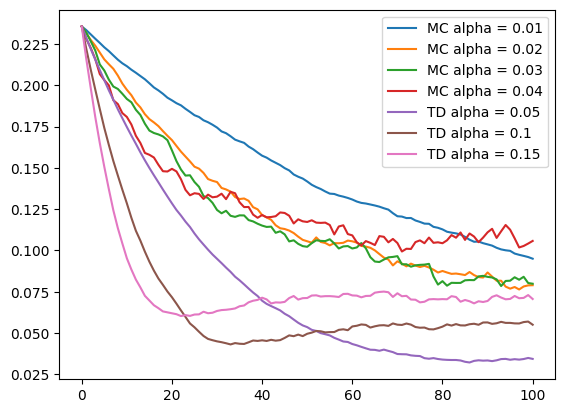

In [3]:
# Q1

# Monte Carlo
for a in [0.01, 0.02, 0.03, 0.04]:
    runs = []
    for i in range(100):
        runs.append(env(alpha=a).learnMC())
    print(f"Learning Completed (MC alpha = {a})")
    plt.plot(np.average(runs, axis=0), label=f'MC alpha = {a}')

# Temporal Difference
for a in [0.05, 0.1, 0.15]:
    runs = []
    for i in range(100):
        runs.append(env(alpha=a).learnTD())
    print(f"Learning Completed (TD alpha = {a})")
    plt.plot(np.average(runs, axis=0), label=f'TD alpha = {a}')

plt.legend()
plt.show()


N:   0%|          | 0/10 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

a:   0%|          | 0/28 [00:00<?, ?it/s]

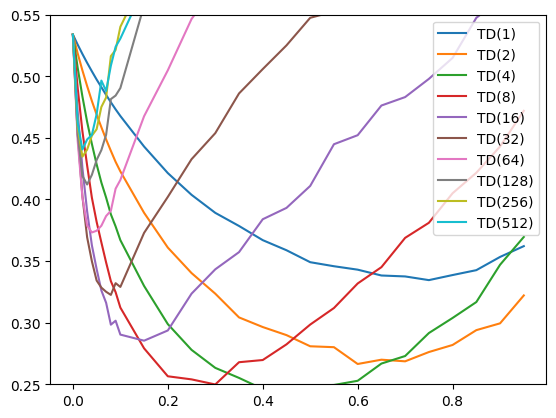

In [5]:
# Q2

alpha = np.append(np.arange(0, 0.1, 0.01), np.arange(0.1, 1, 0.05))
for N in tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512], desc='N', position=0):
    averageRMS = []
    for a in tqdm(alpha, desc='a', position=1, leave=False):
        runs = []
        for i in range(500):
            runs.append(env(alpha=a, num_states=19).learnTDN(n=N))
        averageRMS.append(np.average(runs))
    plt.plot(alpha, averageRMS, label=f'TD({N})')

plt.legend()
plt.ylim(0.25, 0.55)
plt.show()


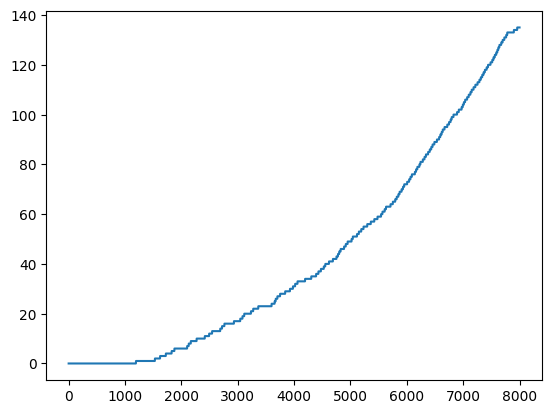

In [6]:
# Q3

Q3 = windyGrid()
plt.plot(Q3.learnSarsa())
plt.show()